# Logistic regression: Handwritten Digit Recognition

This notebook uses the classic [MNIST handwritten digit](http://yann.lecun.com/exdb/mnist/) dataset, which contains digit 0-9 images of size 28*28. We build a logistic regression model to predict the class of digit.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist



## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it. 

In [2]:
help(mnist.load_data)

Help on function load_data in module tensorflow.python.keras.datasets.mnist:

load_data(path='mnist.npz')
    Loads the MNIST dataset.
    
    This is a dataset of 60,000 28x28 grayscale images of the 10 digits,
    along with a test set of 10,000 images.
    More info can be found at the
    [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
    
    Args:
      path: path where to cache the dataset locally
        (relative to `~/.keras/datasets`).
    
    Returns:
      Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.
    
    **x_train**: uint8 NumPy array of grayscale image data with shapes
      `(60000, 28, 28)`, containing the training data. Pixel values range
      from 0 to 255.
    
    **y_train**: uint8 NumPy array of digit labels (integers in range 0-9)
      with shape `(60000,)` for the training data.
    
    **x_test**: uint8 NumPy array of grayscale image data with shapes
      (10000, 28, 28), containing the test data. Pixel values range
      from

In [3]:
# the data, shuffled and split between train and test sets 
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

### Visualize data

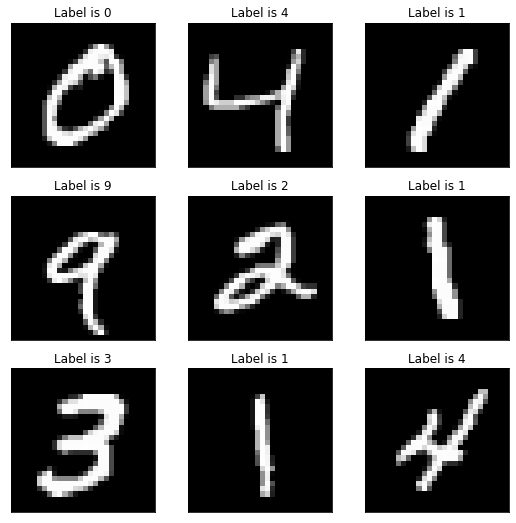

In [4]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    label = y_train_pre[i]
    img = X_train_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Label is {}'.format(label))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

### Reshape and normalize the features

In [5]:
input_dim = 784 # 28*28
X_train = X_train_pre.reshape(X_train_pre.shape[0], input_dim) 
X_test = X_test_pre.reshape(X_test_pre.shape[0], input_dim) 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255. 
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 784)
60000 train samples, 10000 test samples


### convert class vectors to binary class matrices
convert class label to one-hot coding

In [6]:
num_classes = 10 # 0-9
y_train = keras.utils.to_categorical(y_train_pre, num_classes)
y_test = keras.utils.to_categorical(y_test_pre, num_classes)
# the first 5 samples are 5,0,4,1,9
y_train[:5,] 

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## The model

### Build the model

In [7]:
def build_model():
    model = keras.Sequential([layers.Dense(num_classes, 
                                           input_dim=input_dim, 
                                           activation='softmax')])
    
    optimizer = keras.optimizers.RMSprop(0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

In [8]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [10]:
# Display training progress by printing a single dot for each completed epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch == 0: self.time = time.monotonic()
            
    def on_epoch_end(self, epoch, logs):
        # calculate training time
        t = time.monotonic() - self.time
        # if validation set is included, its loss is recorded in logs['val_loss']
        print('| Epoch {:4} | training time {:6.2f}s | train loss {:6.2f} |'
              .format(epoch, t, logs['loss']))

EPOCHS = 10

# use validation_split argument to do train-validation split
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, verbose=0,
                    callbacks=[PrintLoss()])

| Epoch    0 | training time   0.95s | train loss   0.44 |
| Epoch    1 | training time   1.61s | train loss   0.30 |
| Epoch    2 | training time   2.28s | train loss   0.29 |
| Epoch    3 | training time   2.92s | train loss   0.28 |
| Epoch    4 | training time   3.60s | train loss   0.28 |
| Epoch    5 | training time   4.33s | train loss   0.28 |
| Epoch    6 | training time   4.98s | train loss   0.28 |
| Epoch    7 | training time   5.64s | train loss   0.28 |
| Epoch    8 | training time   6.30s | train loss   0.28 |
| Epoch    9 | training time   6.95s | train loss   0.28 |


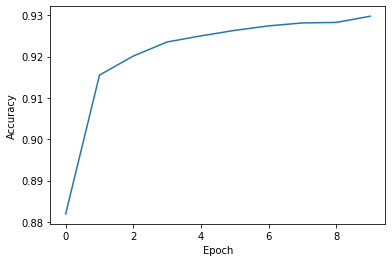

In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'])

    plt.show()

plot_history(history)

### Make predictions

Calculate the classification accuracy for testing set

In [12]:
_, acc = model.evaluate(X_test, y_test, verbose=0)

print("Testing set accuracy: {:.2f}%".format(acc*100))

Testing set accuracy: 92.57%


Make predictions for testing data

In [13]:
y_pred = model.predict_classes(X_test)
y_pred[:5]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([7, 2, 1, 0, 4])

Visualize predictions

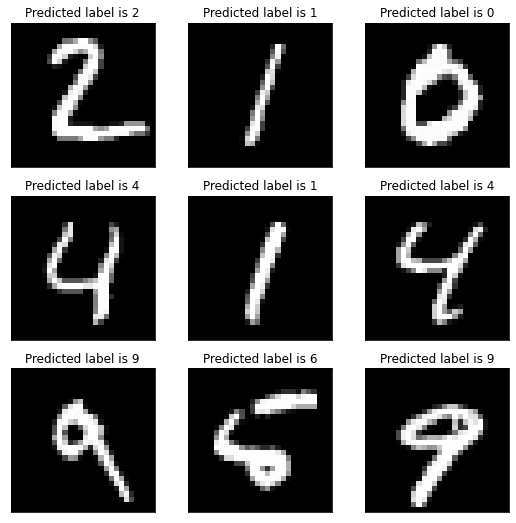

In [14]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    pred = y_pred[i]
    img = X_test_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Predicted label is {}'.format(pred))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()